In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'png'
%matplotlib inline

In [3]:
train = pd.read_csv("data/house_price_train.csv")
test = pd.read_csv("data/house_price_test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# pandas loc accessor is inclusive; but, pandas iloc accessor is not inclusive!
all_data = pd.concat([train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']])
all_data.shape
#all_data.hist()

(2919, 79)

## Data preprocessing
- transform skewed numeric features by taking log(feature+1)
- create dummy variables for the categorical features (one-hot-encoding)
- replace numeric missing values (NaN's) with the mean of their respective columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115a662b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115ae7400>]], dtype=object)

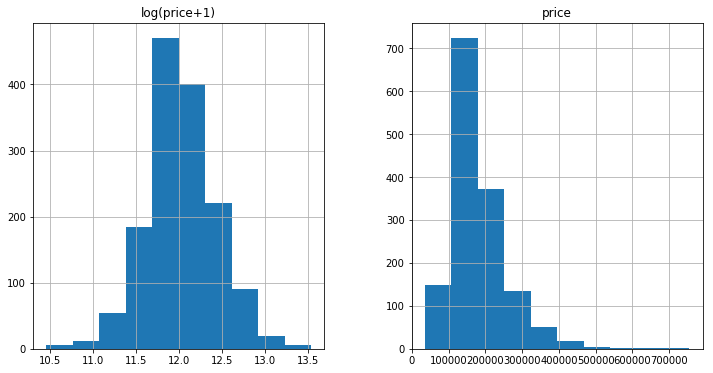

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

# The log transformation can be used to make 
# highly skewed distributions less skewed. 
# This can be valuable both for making patterns 
# in the data more interpretable and for helping 
# to meet the assumptions of inferential statistics.
prices = pd.DataFrame({"price":train["SalePrice"], 
                       "log(price+1)":np.log1p(train["SalePrice"])
                      })
prices.hist()

In [6]:
#log transform the target
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

In [7]:
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [8]:
all_data = pd.get_dummies(all_data) # one-hot-encoding
all_data = all_data.fillna(all_data.mean()) #imputation; mean() is apply-like/row-based operation

In [9]:
#creating matrices for sklearn
X_train = all_data[:train.shape[0]] #not inclusive
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [10]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, 
                                    scoring='neg_mean_squared_error',
                                   cv=5))
    return rmse

In [11]:
# main tuning parameter for the Ridge model is alpha
# the higher the regularization the less prone our model will overfit.
# on the other hand, we might not capture all of the signal in the data.

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]


Text(0,0.5,'RMSE')

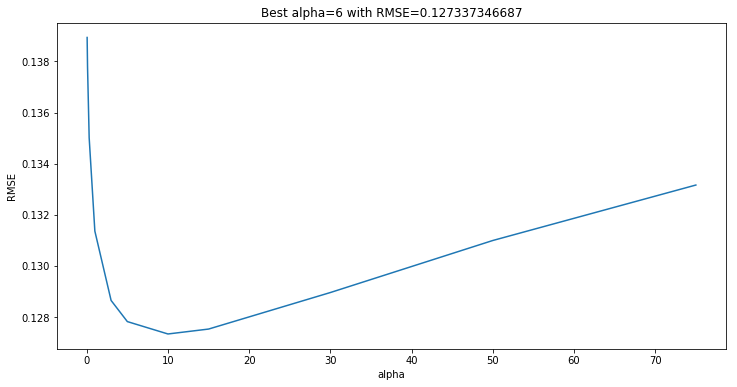

In [12]:
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title='Best alpha=%s with RMSE=%s'%
      (cv_ridge.values.argmin(),cv_ridge.values.min()))
plt.xlabel('alpha')
plt.ylabel('RMSE')

In [13]:
# sanity check with the built-in RidgeCV function
model_ridge = RidgeCV(alphas=alphas).fit(X_train, y)
rmse_cv(model_ridge).mean()

0.12775910042526095

In [14]:
coef = pd.Series(model_ridge.coef_, index=X_train.columns)
print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Ridge picked 288 variables and eliminated the other 0 variables


In [15]:
# alphas in lasso is really the inverse or the alphas in Ridge
model_lasso = LassoCV(alphas=[1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()

0.12314421090977448

In [16]:
# lasso picked features are not necessarily the correct ones.
coef = pd.Series(model_lasso.coef_, index=X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " 
      +  str(sum(coef == 0)) + " variables")

Lasso picked 111 variables and eliminated the other 177 variables


Text(0.5,1,'Coefficients in the Lasso Model')

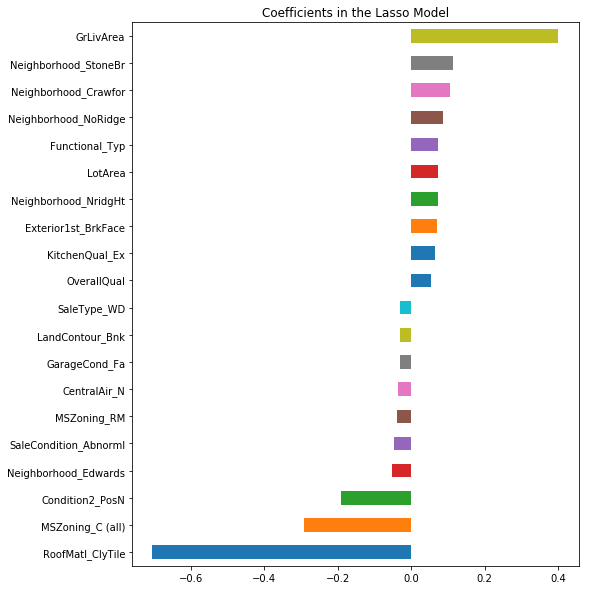

In [17]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = 'barh')
plt.title("Coefficients in the Lasso Model")

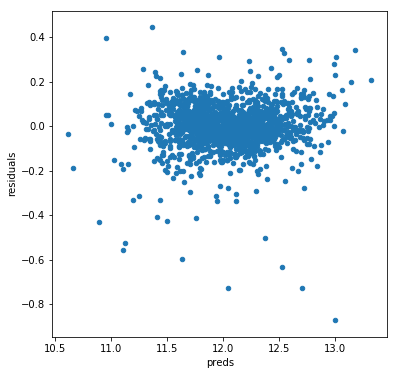

In [18]:
#let's look at the residuals as well
matplotlib.rcParams['figure.figsize'] = (6,6)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train),
                     "true":y})
preds["residuals"] = preds["true"] - preds['preds']
preds.plot(x="preds",y="residuals", kind="scatter")
# which looks pretty good!

## Adding an xgboost model
Compare XGboost to the linear regression model

In [19]:
import xgboost as xgb

In [26]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.03}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

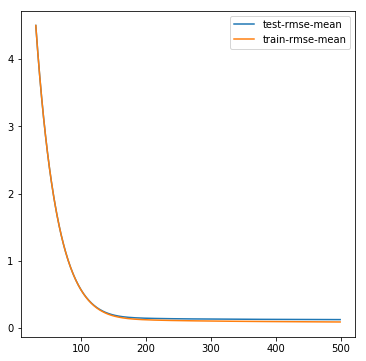

In [27]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [28]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

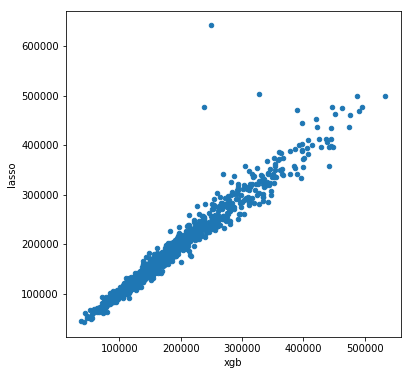

In [29]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [30]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
#solution.to_csv("ridge_sol.csv", index = False)